# Final version of indi RSA

# Trail by trail RDM construction with PCA

In [1]:
# === Step-by-Step: 建立 Neural RDM 的完整 Pipeline with PCA ===
import mne
import numpy as np
import re
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

# Step 1: 讀取 EEG .set 檔案
set_path = "preproc/10_ica_ADJUST.set"
epochs = mne.read_epochs_eeglab(set_path, verbose=False)
print(f"✅ 成功載入 epochs：{epochs}")

# Step 2: 擷取條件 labels
def extract_condition_label(label):
    match = re.search(r'(Left|Right)_(correct|incorrect)_\d', label)
    if match:
        return match.group(0)
    else:
        print(f"[⚠️警告] 無法擷取條件：{label}")
        return 'INVALID'

event_id_rev = {v: k for k, v in epochs.event_id.items()}
event_codes = epochs.events[:, 2]
full_labels = [event_id_rev[code] for code in event_codes]
labels = np.array([extract_condition_label(label) for label in full_labels])

# 統計有效 label 數量
label_counts = Counter(labels)
print("✅ 有效條件的 trial 數：")
for label, count in label_counts.items():
    if label != 'INVALID':
        print(f"{label}: {count} trials")

# 過濾 INVALID trial
valid_mask = labels != 'INVALID'
data = epochs.get_data()[valid_mask]
labels = labels[valid_mask]
times = epochs.times
sfreq = epochs.info['sfreq']

# Step 3: Trial-wise Neural RDM + PCA降維（保留 99% 變異）
def compute_trialwise_rdms_with_pca(data, times, sfreq, bin_ms=50, explained_var=0.99):
    bin_samples = int(sfreq * bin_ms / 1000)
    n_times = data.shape[2]
    n_bins = n_times - bin_samples + 1

    final_rdms = []
    time_centers = []
    n_components_all = []

    for start in tqdm(range(n_bins), desc="Time bins"):
        end = start + bin_samples
        X = data[:, :, start:end].reshape(len(data), -1)  # trial × feature

        # --- PCA 降維 ---
        pca = PCA()
        X_pca = pca.fit_transform(X)
        # 計算需要幾個主成分能保留足夠變異
        n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= explained_var) + 1
        X_pca = X_pca[:, :n_components]
        n_components_all.append(n_components)

        if X_pca.shape[0] < 2:
            continue

        rdm = 1 - np.corrcoef(X_pca)
        final_rdms.append(rdm)
        time_centers.append(times[start:end].mean())

    print(f"每個 time bin 保留的 PCA 維度（主成分數）：")
    print(n_components_all)
    return np.stack(final_rdms), np.array(time_centers), np.array(n_components_all)

# Step 4: 執行計算
rdms_trialwise_pca, time_centers_trialwise, n_components_all = compute_trialwise_rdms_with_pca(
    data, times, sfreq, bin_ms=50, explained_var=0.99
)
print("✅ Trial-wise RDM（PCA降維）計算完成！")

/var/folders/qn/m3f3dhd10sd5t6_dbhwf4g8w0000gn/T/ipykernel_65610/1723903513.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(set_path, verbose=False)


✅ 成功載入 epochs：<EpochsEEGLAB | 218 events (all good), -2 – 1.496 s (baseline off), ~93.2 MB, data loaded,
 '102/99/Left_correct_1/11/20': 6
 '101/99/Left_incorrect_0/10/21/100': 3
 '100/99/Right_correct_0/11/21': 5
 '101/99/Right_correct_0/11/21': 6
 '100/99/Right_correct_0/11/21/100': 3
 '13/20/102/99/Right_correct_1/11/21/101': 1
 '13/20/102/99/Right_correct_0/11/21/100': 1
 '11/21/100/99/Right_correct_0/11/21': 1
 '13/21/102/99/Right_correct_1/11/21': 1
 '101/99/Right_correct_0/11/21/100': 1
 and 66 more events ...>
✅ 有效條件的 trial 數：
Left_correct_1: 53 trials
Left_incorrect_0: 53 trials
Right_correct_0: 34 trials
Right_correct_1: 59 trials
Right_correct_2: 7 trials
Right_correct_3: 2 trials
Left_incorrect_1: 8 trials
Left_correct_2: 1 trials
Left_correct_3: 1 trials


Time bins: 100%|██████████| 864/864 [00:43<00:00, 20.06it/s]

每個 time bin 保留的 PCA 維度（主成分數）：
[88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 90, 90, 90, 90, 90, 91, 91, 91, 91, 92, 92, 92, 93, 93, 93, 93, 93, 94, 94, 95, 95, 95, 96, 96, 97, 97, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 97, 97, 97, 97, 97, 97, 98, 97, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 100, 100, 100, 100, 101, 101, 101, 102, 102, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 101, 102, 102, 103, 103, 103, 104, 104, 104, 104, 104, 105, 105, 105, 106, 106, 106, 106, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 106, 107, 107, 107, 108, 108, 109, 109, 109, 110, 110, 111, 111, 111, 111, 112, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114, 114, 114, 115, 116, 116, 116, 116, 117, 117, 118, 118, 119, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 119, 119, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 122, 122, 

In [2]:
import plotly.graph_objects as go
import ipywidgets as widgets
import numpy as np

def plot_interactive_trial_rdm(rdms, time_centers):
    """
    使用 ipywidgets + plotly 視覺化 trial-wise RDM，並以滑桿選擇時間點。

    Parameters:
    - rdms: ndarray, shape = [n_time_bins, n_trials, n_trials]
    - time_centers: ndarray, shape = [n_time_bins]
    """
    zero_locked_times = time_centers - 0  # 若你希望是相對於事件的 0 s，可做進一步調整

    # 設定滑桿（單位：秒）
    slider = widgets.FloatSlider(
        value=zero_locked_times[0],
        min=zero_locked_times.min(),
        max=zero_locked_times.max(),
        step=0.050,  # 每格 50ms
        description='Time (s)',
        continuous_update=False,
        readout_format='.3f'
    )

    def plot_rdm(selected_time):
        # 找出最接近該時間點的 index
        idx = np.argmin(np.abs(zero_locked_times - selected_time))
        rdm = rdms[idx]
        fig = go.Figure(data=go.Heatmap(
            z=rdm,
            x=[f"trial_{i}" for i in range(rdm.shape[0])],
            y=[f"trial_{i}" for i in range(rdm.shape[0])],
            zmin=0, zmax=2,
            colorscale='Viridis',
            colorbar=dict(title='1 - r')
        ))
        fig.update_layout(
            title=f"Trial-wise Neural RDM at {zero_locked_times[idx]*1000:.0f} ms (relative to event)",
            xaxis_title="Trial Index",
            yaxis_title="Trial Index",
            width=650,
            height=650
        )
        fig.show()

    widgets.interact(plot_rdm, selected_time=slider)

# ✅ 呼叫並可視化 PCA 降維後的 RDM 結果
plot_interactive_trial_rdm(rdms_trialwise_pca, time_centers_trialwise)
print("✅ 完成所有步驟，包括可視化（滑桿版）！")

interactive(children=(FloatSlider(value=-1.978, continuous_update=False, description='Time (s)', max=1.474, mi…

✅ 完成所有步驟，包括可視化（滑桿版）！


# Construct Behavioural RDMs

In [3]:
def extract_behavioral_attributes(labels):
    """從原始條件標籤中提取 correctness, clarity, hemifield 三個行為變項"""
    correctness = []
    clarity = []
    hemifield = []

    for label in labels:
        # correctness: correct / incorrect
        if 'incorrect' in label:
            correctness.append(0)  # correct >> incorrent
        elif 'correct' in label:
            correctness.append(1)  # incorrect >> correct
        else:
            raise ValueError(f"無法判別 correctness: {label}")

        # clarity: 最後的數字
        match = re.search(r'_(\d)$', label)
        if match:
            clarity.append(int(match.group(1)))
        else:
            raise ValueError(f"無法擷取 clarity: {label}")

        # hemifield: Left / Right
        if 'Left' in label:
            hemifield.append(0)  # Left
        elif 'Right' in label:
            hemifield.append(1)  # Right
        else:
            raise ValueError(f"無法判別 hemifield: {label}")

    return np.array(correctness), np.array(clarity), np.array(hemifield)

def compute_behavior_rdm(values):
    """計算行為變項的 Representational Dissimilarity Matrix (RDM)，使用歐式距離"""
    return np.abs(values[:, None] - values[None, :])  # pairwise distance

# === 使用方式 ===
correctness_vec, clarity_vec, hemifield_vec = extract_behavioral_attributes(labels)

rdm_correctness = compute_behavior_rdm(correctness_vec)
rdm_clarity     = compute_behavior_rdm(clarity_vec)
rdm_hemifield   = compute_behavior_rdm(hemifield_vec)

print("✅ 已成功建立行為層次的 RDMs！")

✅ 已成功建立行為層次的 RDMs！


In [4]:
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import display

# === 行為 RDMs 包裝成字典 ===
behavior_rdms = {
    "Correctness (0=incorrect, 1=correct)": rdm_correctness,
    "Clarity (0~3 levels)": rdm_clarity,
    "Hemifield (0=Left, 1=Right)": rdm_hemifield
}

def plot_behavior_rdm(rdm_name):
    rdm = behavior_rdms[rdm_name]
    fig = go.Figure(data=go.Heatmap(
        z=rdm,
        colorscale='Viridis',
        colorbar=dict(title="Dissimilarity")
    ))

    fig.update_layout(
        title=f"{rdm_name} - Behavioral RDM",
        xaxis=dict(title="Trial Index"),
        yaxis=dict(title="Trial Index"),
        width=600,
        height=500
    )
    fig.show()

# 下拉式選單
dropdown = widgets.Dropdown(
    options=list(behavior_rdms.keys()),
    value=list(behavior_rdms.keys())[0],  # 預設顯示第一個
    description="Select RDM:"
)

# 啟用互動式圖表
widgets.interact(plot_behavior_rdm, rdm_name=dropdown)

interactive(children=(Dropdown(description='Select RDM:', options=('Correctness (0=incorrect, 1=correct)', 'Cl…

<function __main__.plot_behavior_rdm(rdm_name)>

# Time-resolved RSA

## RSA after PCA

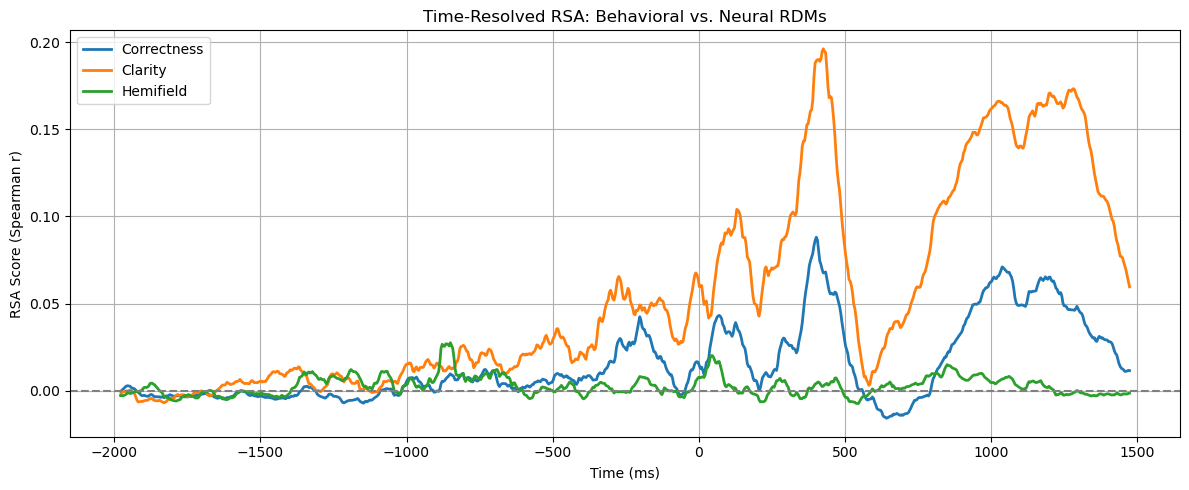

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def compute_rsa_timecourse(neural_rdms, behavioral_rdm):
    """計算 RSA 分數（Spearman correlation）時間序列"""
    rsa_scores = []
    for neural_rdm in neural_rdms:
        # 將上三角攤平成向量（避免重複 & 排除對角線）
        i_upper = np.triu_indices_from(neural_rdm, k=1)
        neural_vec = neural_rdm[i_upper]
        behavior_vec = behavioral_rdm[i_upper]
        r, _ = spearmanr(neural_vec, behavior_vec)
        rsa_scores.append(r)
    return np.array(rsa_scores)

# === 將你的變數指派進來（請替換成你自己的）===
# 這些變數應已存在：
# rdms_avg → neural RDMs, shape (n_bins, n_cond, n_cond)
# rdm_correctness, rdm_clarity, rdm_hemifield → 你的行為 RDMs, shape (n_cond, n_cond)
# time_centers_avg → 對應的時間（長度為 n_bins）

rsa_correctness = compute_rsa_timecourse(rdms_trialwise_pca, rdm_correctness)
rsa_clarity = compute_rsa_timecourse(rdms_trialwise_pca, rdm_clarity)
rsa_hemifield = compute_rsa_timecourse(rdms_trialwise_pca, rdm_hemifield)

# === 繪圖展示 ===
plt.figure(figsize=(12, 5))
plt.plot(time_centers_trialwise * 1000, rsa_correctness, label='Correctness', linewidth=2)
plt.plot(time_centers_trialwise * 1000, rsa_clarity, label='Clarity', linewidth=2)
plt.plot(time_centers_trialwise * 1000, rsa_hemifield, label='Hemifield', linewidth=2)

plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('RSA Score (Spearman r)')
plt.title('Time-Resolved RSA: Behavioral vs. Neural RDMs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# === Step 6: 互動式視覺化+PCA ===
def plot_interactive_rsa_comparison(time_points, rsa_dict):
    dropdown = widgets.Dropdown(
        options=list(rsa_dict.keys()),
        value=list(rsa_dict.keys())[0],
        description='Behavior RDM:'
    )

    def update_plot(rdm_name):
        rsa = rsa_dict[rdm_name]
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=time_points, y=rsa, mode='lines+markers', name='RSA'))
        fig.update_layout(title=f"RSA(PCA) Timecourse for {rdm_name}",
                          xaxis_title="Time (s)",
                          yaxis_title="RSA (Spearman correlation)",
                          height=400)
        fig.show()

    widgets.interact(update_plot, rdm_name=dropdown)

plot_interactive_rsa_comparison(
    time_points=time_centers_trialwise,
    rsa_dict={
        "Correctness": rsa_correctness,
        "Clarity": rsa_clarity,
        "Hemifield": rsa_hemifield
    }
)

print("\u2705 完成 RSA 分析與互動式可視化整合！")

interactive(children=(Dropdown(description='Behavior RDM:', options=('Correctness', 'Clarity', 'Hemifield'), v…

✅ 完成 RSA 分析與互動式可視化整合！


## 存檔

In [7]:
#=====儲存RSA分析結果+PCA======
import os
import numpy as np

subject_id = "subj10"  # 換成對應的 subject 代碼
outdir = f"./{subject_id}"

# 若資料夾不存在則自動建立
os.makedirs(outdir, exist_ok=True)

np.save(f"{outdir}/rsa_correctness_pca.npy", rsa_correctness)
np.save(f"{outdir}/rsa_clarity_pca.npy", rsa_clarity)
np.save(f"{outdir}/rsa_hemifield_pca.npy", rsa_hemifield)
np.save(f"{outdir}/time_centers_trialwise_pca.npy", time_centers_trialwise)

## RSA with permutation null distribution testing, p-value and 95% confidence intervals with marked statistical significant regions

In [8]:
# === Step 5: RSA 分析平行處理+單側三角+PCA ===
from scipy.stats import spearmanr
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

def compute_rsa_timecourse(neural_rdms, behavioral_rdm):
    behavioral_flat = behavioral_rdm[np.triu_indices_from(behavioral_rdm, k=1)]
    return np.array([
        spearmanr(rdm[np.triu_indices_from(rdm, k=1)], behavioral_flat).correlation
        for rdm in neural_rdms
    ])

# === 多核加速 permutation_rsa ===
def permutation_rsa(neural_rdms, behavioral_rdm, n_perm=1000, n_jobs=-1):
    observed = compute_rsa_timecourse(neural_rdms, behavioral_rdm)
    # 平行化每個 permutation
    def single_perm(_):
        shuffled = np.random.permutation(behavioral_rdm.ravel()).reshape(behavioral_rdm.shape)
        return compute_rsa_timecourse(neural_rdms, shuffled)
    null_dists = Parallel(n_jobs=n_jobs)(
        delayed(single_perm)(_) for _ in tqdm(range(n_perm), desc='Permuting')
    )
    return observed, np.array(null_dists)

def compute_ci(null_distribution, ci=95):
    lower = np.percentile(null_distribution, (100 - ci) / 2, axis=0)
    upper = np.percentile(null_distribution, 100 - (100 - ci) / 2, axis=0)
    return lower, upper

def compute_p_values(observed, null_distribution):
    return np.mean(np.abs(null_distribution) >= np.abs(observed[None, :]), axis=0)

# ==== 直接用法（其餘不用動）====
rsa_correctness, null_correctness = permutation_rsa(rdms_trialwise_pca, rdm_correctness, n_perm=1000, n_jobs=-1)
ci_lower_correctness, ci_upper_correctness = compute_ci(null_correctness)
p_values_correctness = compute_p_values(rsa_correctness, null_correctness)

rsa_clarity, null_clarity = permutation_rsa(rdms_trialwise_pca, rdm_clarity, n_perm=1000, n_jobs=-1)
ci_lower_clarity, ci_upper_clarity = compute_ci(null_clarity)
p_values_clarity = compute_p_values(rsa_clarity, null_clarity)

rsa_hemifield, null_hemifield = permutation_rsa(rdms_trialwise_pca, rdm_hemifield, n_perm=1000, n_jobs=-1)
ci_lower_hemifield, ci_upper_hemifield = compute_ci(null_hemifield)
p_values_hemifield = compute_p_values(rsa_hemifield, null_hemifield)


Permuting:   1%|          | 12/1000 [00:00<00:26, 37.23it/s]Traceback (most recent call last):
  File "/opt/anaconda3/envs/EEG/lib/python3.9/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 281, in main
    registry[rtype][name] -= 1
KeyError: '/var/folders/qn/m3f3dhd10sd5t6_dbhwf4g8w0000gn/T/joblib_memmapping_folder_65610_0cf9b02c021c4792bb9f91a120d8ea22_0c3abab8836047648d896c93172d438f/65610-14192311120-e7a0f505168949cebf914bdd66397b1c.pkl'
Traceback (most recent call last):
  File "/opt/anaconda3/envs/EEG/lib/python3.9/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 281, in main
    registry[rtype][name] -= 1
KeyError: '/var/folders/qn/m3f3dhd10sd5t6_dbhwf4g8w0000gn/T/joblib_memmapping_folder_65610_0cf9b02c021c4792bb9f91a120d8ea22_0c3abab8836047648d896c93172d438f/65610-14192311120-e7a0f505168949cebf914bdd66397b1c.pkl'
Traceback (most recent call last):
  File "/opt/anaconda3/envs/EEG/lib/python3.9/site-packages/joblib/externals/loky/backe

KeyboardInterrupt: 

Permuting:   1%|          | 12/1000 [00:18<00:26, 37.23it/s]

In [ ]:
# === Step 6: 互動式視覺化 RSA 結果+PCA ===
def plot_interactive_rsa_pca_comparison(time_points, rsa_dict, ci_dict=None, pval_dict=None):
    dropdown = widgets.Dropdown(
        options=list(rsa_dict.keys()),
        value=list(rsa_dict.keys())[0],
        description="Select RDM:"
    )

    def update_plot(rdm_name):
        y = rsa_dict[rdm_name]
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=time_points, y=y, mode='lines', name='RSA'))

        if ci_dict:
            lower, upper = ci_dict[rdm_name]
            fig.add_trace(go.Scatter(x=time_points, y=upper, mode='lines', name='Upper CI', line=dict(dash='dash')))
            fig.add_trace(go.Scatter(x=time_points, y=lower, mode='lines', name='Lower CI', line=dict(dash='dash')))
            fig.add_trace(go.Scatter(x=np.concatenate([time_points, time_points[::-1]]),
                                     y=np.concatenate([lower, upper[::-1]]),
                                     fill='toself', fillcolor='rgba(0,100,80,0.2)', line=dict(color='rgba(255,255,255,0)'),
                                     name='95% CI'))

        if pval_dict:
            sig_mask = pval_dict[rdm_name] < 0.05
            fig.add_trace(go.Scatter(
                x=time_points[sig_mask],
                y=[y[i] for i in range(len(y)) if sig_mask[i]],
                mode='markers', marker=dict(color='red', size=6),
                name='p < .05'))
                        # ➤ 最早顯著點
            if np.any(sig_mask):
                first_sig_idx = np.where(sig_mask)[0][0]
                first_sig_time = time_points[first_sig_idx]
                fig.add_vline(
                    x=first_sig_time,
                    line=dict(dash='dot', color='black'),
                    annotation_text=f"First sig: {first_sig_time*1000:.0f} ms",
                    annotation_position="top left"
                )
                    # ➤ 時間 0s 之後第一個顯著點
                post_zero_mask = sig_mask & (time_points > 0)
                if np.any(post_zero_mask):
                    post_zero_idx = np.where(post_zero_mask)[0][0]
                    post_zero_time = time_points[post_zero_idx]
                    fig.add_vline(
                        x=post_zero_time,
                        line=dict(dash='dot', color='orange'),
                        annotation_text=f"1st sig after 0: {post_zero_time*1000:.0f} ms",
                        annotation_position="bottom left"
                    )
                    
            # ➤ 最大 effect size 點
            max_idx = np.argmax(np.abs(y))  # 最大正負皆可
            max_time = time_points[max_idx]
            fig.add_vline(
                x=max_time,
                line=dict(dash='dashdot', color='blue'),
                annotation_text=f"Max effect: {max_time*1000:.0f} ms",
                annotation_position="top right"
            )
            
        fig.update_layout(
            title=f"RSA(PCA): {rdm_name}",
            xaxis_title="Time (s)",
            yaxis_title="RSA Correlation (Spearman)",
            width=800, height=500)
        fig.show()

    widgets.interact(update_plot, rdm_name=dropdown)

plot_interactive_rsa_pca_comparison(
    time_points=time_centers_trialwise,
    rsa_dict={
        "Correctness": rsa_correctness,
        "Clarity": rsa_clarity,
        "Hemifield": rsa_hemifield
    },
    ci_dict={
        "Correctness": (ci_lower_correctness, ci_upper_correctness),
        "Clarity": (ci_lower_clarity, ci_upper_clarity),
        "Hemifield": (ci_lower_hemifield, ci_upper_hemifield)
    },
    pval_dict={
        "Correctness": p_values_correctness,
        "Clarity": p_values_clarity,
        "Hemifield": p_values_hemifield
    }
)

print("✅ 完成整合：包含 permutation test 與交互式 RSA 可視化！")

interactive(children=(Dropdown(description='Select RDM:', options=('Correctness', 'Clarity', 'Hemifield'), val…

✅ 完成整合：包含 permutation test 與交互式 RSA 可視化！


# Split-half reliability

In [ ]:
# Step 5: Split-half reliability（信度）不支援多核心加速
def compute_split_half_reliability(data, labels, times, sfreq, bin_ms=50, explained_var=0.99, n_repeats=50):
    bin_samples = int(sfreq * bin_ms / 1000)
    n_times = data.shape[2]
    n_bins = n_times - bin_samples + 1

    reliabilities = []

    for start in tqdm(range(n_bins), desc="Split-half reliability"):
        end = start + bin_samples
        X = data[:, :, start:end].reshape(len(data), -1)

        corr_list = []
        for _ in range(n_repeats):
            perm = np.random.permutation(len(labels))
            half = len(labels) // 2
            idx1, idx2 = perm[:half], perm[half:]
            X1, X2 = X[idx1], X[idx2]

            # 分別對兩半做PCA（或可只對第一半fit pca，再transform第二半）
            pca = PCA()
            X1_pca = pca.fit_transform(X1)
            n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= explained_var) + 1
            X1_pca = X1_pca[:, :n_components]
            X2_pca = pca.transform(X2)[:, :n_components]

            # 計算split-half的RDM
            if X1_pca.shape[0] < 2 or X2_pca.shape[0] < 2:
                continue
            rdm1 = 1 - np.corrcoef(X1_pca)
            rdm2 = 1 - np.corrcoef(X2_pca)

            # 展平成一維，做相關係數（去掉對角線）
            idx_flat = np.triu_indices_from(rdm1, k=1)
            flat1 = rdm1[idx_flat]
            flat2 = rdm2[idx_flat]
            corr = spearmanr(flat1, flat2).correlation
            corr_list.append(corr)
        if len(corr_list) > 0:
            reliabilities.append(np.mean(corr_list))
        else:
            reliabilities.append(np.nan)
    return np.array(reliabilities)

# 計算 split-half reliability

reliabilities = compute_split_half_reliability(data, labels, times, sfreq, bin_ms=50, explained_var=0.99, n_repeats=50)
print("✅ Split-half reliability 計算完成！")

# Step 6: 視覺化（舉例：reliability 隨時間變化）
plt.figure(figsize=(10,4))
plt.plot(time_centers_trialwise, reliabilities)
plt.xlabel("Time (s)")
plt.ylabel("Split-half reliability (Spearman)")
plt.title("Neural RDM Split-half Reliability over Time")
plt.show()

In [ ]:
# 輸出指定時間reliability

print(f"Time bin 100 的 split-half reliability: {reliabilities[100]:.3f}")

# print out all
print("每個 time bin 的 split-half reliability 值：")
for t, r in zip(time_centers_trialwise, reliabilities):
    print(f"Time {t:.3f} s:  reliability = {r:.3f}")

print(f"\n--- Summary ---")
print(f"Mean reliability: {np.nanmean(reliabilities):.4f}")
print(f"Max reliability: {np.nanmax(reliabilities):.4f}")
print(f"Min reliability: {np.nanmin(reliabilities):.4f}")

In [ ]:
# Step 5: Split-half reliability（信度）支援多核心加速
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import ipywidgets as widgets

try:
    from joblib import Parallel, delayed
    JOBLIB_AVAILABLE = True
except ImportError:
    JOBLIB_AVAILABLE = False

# === Split-half reliability function (single-bin) ===
def compute_single_bin_reliability(X, n_trials, explained_var=0.99, n_repeats=50):
    corrs = []
    for _ in range(n_repeats):
        perm = np.random.permutation(n_trials)
        half = n_trials // 2
        idx1, idx2 = perm[:half], perm[half:]
        X1, X2 = X[idx1], X[idx2]
        pca = PCA()
        X1_pca = pca.fit_transform(X1)
        n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= explained_var) + 1
        X1_pca = X1_pca[:, :n_components]
        X2_pca = pca.transform(X2)[:, :n_components]
        if X1_pca.shape[0] < 2 or X2_pca.shape[0] < 2:
            continue
        rdm1 = 1 - np.corrcoef(X1_pca)
        rdm2 = 1 - np.corrcoef(X2_pca)
        idx_flat = np.triu_indices_from(rdm1, k=1)
        flat1 = rdm1[idx_flat]
        flat2 = rdm2[idx_flat]
        corr = spearmanr(flat1, flat2).correlation
        corrs.append(corr)
    return np.nanmean(corrs) if len(corrs) else np.nan

# === Split-half reliability computation (with parallel option) ===
def compute_split_half_reliability(
    data, times, sfreq, bin_ms=50, explained_var=0.99, n_repeats=50, n_jobs=1, use_parallel=True
):
    bin_samples = int(sfreq * bin_ms / 1000)
    n_times = data.shape[2]
    n_bins = n_times - bin_samples + 1
    n_trials = data.shape[0]
    def process_one_bin(start):
        end = start + bin_samples
        X = data[:, :, start:end].reshape(n_trials, -1)
        return compute_single_bin_reliability(X, n_trials, explained_var, n_repeats)

    if use_parallel and JOBLIB_AVAILABLE and n_jobs != 1:
        from joblib import Parallel, delayed
        reliabilities = Parallel(n_jobs=n_jobs)(
            delayed(process_one_bin)(start) for start in tqdm(range(n_bins), desc=f"Rel. (PCA={explained_var:.2f})")
        )
    else:
        reliabilities = [process_one_bin(start) for start in tqdm(range(n_bins), desc=f"Rel. (PCA={explained_var:.2f})")]
    return np.array(reliabilities)

# === Example usage ===
reliabilities = compute_split_half_reliability(data, times, sfreq, bin_ms=50, explained_var=0.99, n_repeats=50, n_jobs=-1, use_parallel=True)

In [ ]:
# === Interactive summary plot ===
def plot_interactive_reliability_summary(time_axis, reliability_curves, sig_level=0.2, stim_onset_time=0.0):
    options = list(reliability_curves.keys())
    min_len = min([len(v) for v in reliability_curves.values()])
    zero_locked_times = time_axis[:min_len] - stim_onset_time
    
    dropdown = widgets.Dropdown(options=options, value=options[0], description='PCA條件:')
    slider = widgets.IntSlider(min=0, max=min_len-1, value=0, step=1, description='Time bin')

    def update(curve_key, bin_idx):
        rel = reliability_curves[curve_key][:min_len]
        t = zero_locked_times

        max_idx = np.nanargmax(rel)
        min_idx = np.nanargmin(rel)
        sig_mask = rel > sig_level

        plt.figure(figsize=(12, 5))
        plt.plot(t, rel, linewidth=2, label='Reliability curve')
        plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(0, color='orange', linestyle='--', label='Stimulus onset')
        # 選中時間點
        plt.scatter([t[bin_idx]], [rel[bin_idx]], color='red', s=100, label='Selected')
        # 顯著性點
        if np.any(sig_mask):
            plt.scatter(t[sig_mask], rel[sig_mask], color='red', s=30, label=f'> {sig_level} sig.', alpha=0.7)
        # 最大最小
        plt.scatter([t[max_idx]], [rel[max_idx]], color='blue', s=80, label=f'Max: {rel[max_idx]:.3f}')
        plt.text(t[max_idx], rel[max_idx], f"Max: {rel[max_idx]:.3f}", fontsize=11, color='blue', va='bottom', ha='right')
        plt.scatter([t[min_idx]], [rel[min_idx]], color='purple', s=80, label=f'Min: {rel[min_idx]:.3f}')
        plt.text(t[min_idx], rel[min_idx], f"Min: {rel[min_idx]:.3f}", fontsize=11, color='purple', va='top', ha='left')

        plt.xlabel('Time (s, stimulus onset at 0)')
        plt.ylabel('Split-half reliability')
        plt.title(f'Split-half Reliability ({curve_key}), Bin {bin_idx} ({t[bin_idx]:.3f}s)')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # print summary
        print(f"Selected time: {t[bin_idx]:.3f}s, reliability: {rel[bin_idx]:.4f}")
        print(f"Max reliability: {rel[max_idx]:.4f} at {t[max_idx]:.3f} s")
        print(f"Min reliability: {rel[min_idx]:.4f} at {t[min_idx]:.3f} s")
        if np.any(sig_mask):
            sig_times = t[sig_mask]
            print(f"Significant (>{sig_level}) bins at:")
            print(", ".join([f"{s:.3f}s" for s in sig_times]))
        else:
            print(f"No bins above significance threshold ({sig_level}).")

    widgets.interact(update, curve_key=dropdown, bin_idx=slider)

# ======= How to use the pipeline =======
# 計算多種 PCA 條件的 split-half reliability 曲線
explained_var_list = [0.90, 0.95, 0.99]
reliability_curves = {}
for expv in explained_var_list:
    reliability_curves[f"PCA {expv:.2f}"] = compute_split_half_reliability(
        data, times, sfreq, bin_ms=50, explained_var=expv, n_repeats=50, n_jobs=-1, use_parallel=True)